# LSTM Mapper

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"

import numpy as np
import matplotlib.pyplot as plt
from vae_model import vae_model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv2D,
    Flatten,
    TimeDistributed,
    Reshape,
    Activation,
    LSTM,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from pyeit import mesh
import random
from glob import glob
from util import (
    ensure_dir,
    load_data,
    calculate_perm_error,
    create_mesh,
    mesh_plot_comparisons,
    select_random_instances,
    plot_boxplot,
    seq_data,
    plot_mesh_permarray,
)

# Creating a mesh
mesh_obj = create_mesh()

2024-12-17 09:39:27.436937: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-17 09:39:28.192159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-17 09:39:39.383882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4c:00.0, compute capability: 8.0
2024-12-17 09:39:39.385705: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79087 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:84:00.0, compute capability: 8.0


**Load data**

Time of
	first: 2024.10.22. 07:55:16.121000
	last: 2024.10.22. 08:04:39.642000
measurement.
Shape of EIT data: (20776, 32, 32)
Shape of Permittivity Data: (20776, 2840)


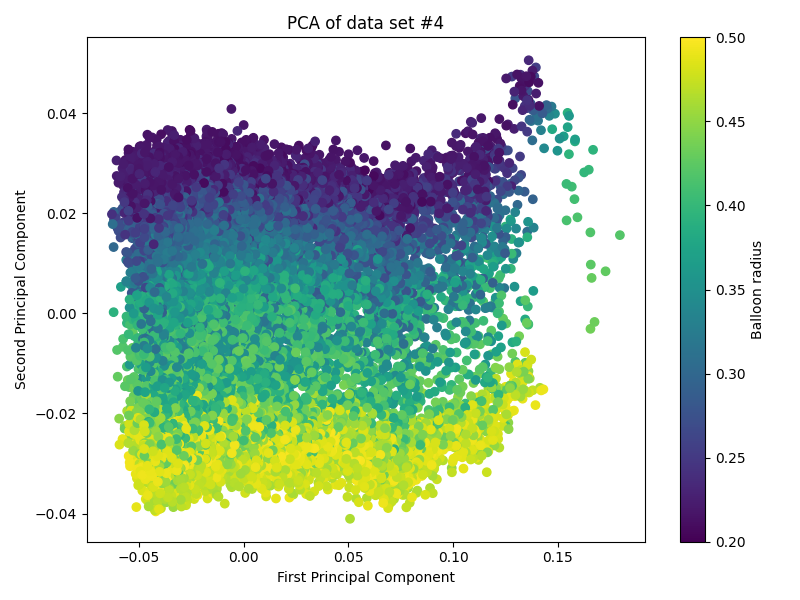

In [2]:
data_set = 4  # select dataset
iteration = 1
# good:1,3,4,7
# bad: 2,5,6
EIT, perm_array, D, T = load_data(data_set)

perm_array = perm_array / 15
# reshape data
EIT = EIT.reshape(-1, 32, 32, 1)
perm_array = perm_array.reshape(-1, 2840, 1)

**Create sequenced data**

In [3]:
EIT_seq, perm_array_seq = seq_data(EIT, perm_array, n_seg=4)
# EIT_seq = EIT_seq.reshape(EIT_seq.shape[0], 4, 1024, 1)
print("New Shape of Voltages Data:")
print(EIT_seq.shape)
print("New Shape of Permittivity Data:")
print(perm_array_seq.shape)

New Shape of Voltages Data:
(20772, 4, 32, 32, 1)
New Shape of Permittivity Data:
(20772, 2840, 1)


**Initialization of pretrained VAE**

In [4]:
weights_dir = "weights"
ensure_dir(weights_dir)

In [5]:
vae = vae_model()
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [6]:
vae_weights_file = os.path.join(weights_dir, "vae_2.weights.h5")

# Load the weights if they exist
if os.path.exists(vae_weights_file):
    vae.load_weights(vae_weights_file)
    print("VAE weights loaded from file.")
else:
    raise FileNotFoundError(
        "No trained VAE model found. Please train the VAE model first."
    )

VAE weights loaded from file.


/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 146 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
_, _, latent_rep = vae.encoder.predict(perm_array_seq)

I0000 00:00:1734424874.769492   31197 service.cc:145] XLA service 0x7b9638004940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734424874.769539   31197 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
I0000 00:00:1734424874.769545   31197 service.cc:153]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-12-17 09:41:14.800255: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-17 09:41:16.667315: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 77/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

I0000 00:00:1734424877.584239   31197 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


650/650 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


In [53]:
(
    x_train_seq,
    x_test_seq,
    y_train_seq,
    y_test_seq,
    z_train_seq,
    z_test_seq,
) = train_test_split(
    EIT_seq,
    perm_array_seq,
    latent_rep,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)

**LSTM Mapper**

In [54]:
def mapper_model(input_shape=(4, 32, 32, 1), output_shape=8):
    mapper_inputs = Input(shape=input_shape)

    x = TimeDistributed(
        Conv2D(2, strides=(2, 2), kernel_size=(3, 3), activation="elu")
    )(mapper_inputs)
    x = TimeDistributed(
        Conv2D(2, strides=(2, 2), kernel_size=(3, 3), activation="elu")
    )(x)
    x = TimeDistributed(Flatten())(x)

    x = TimeDistributed(Dense(64, activation="elu"))(x)

    x = LSTM(32, return_sequences=True)(x)
    x = LSTM(16, return_sequences=False)(x)

    mapper_output = Dense(output_shape)(x)
    model = Model(mapper_inputs, mapper_output, name="lstm_mapper")
    return model


lstm_mapper = mapper_model()
lstm_mapper.compile(optimizer="adam", loss="mse")
lstm_mapper.summary()

Model: "lstm_mapper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 4, 32, 32, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 4, 15, 15, 2)   │            20 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 4, 7, 7, 2)     │            38 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 4, 98)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 4, 64)          │         6,336 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 4, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,082 (86.26 KB)

 Trainable params: 22,082 (86.26 KB)

 Non-trainable params: 0 (0.00 B)

**LSTM Mapper training**

Epoch 1/200
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.9367 - val_loss: 0.9364
Epoch 2/200
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.9287 - val_loss: 0.9366
Epoch 3/200
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.9332 - val_loss: 0.9355
Epoch 4/200
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.9251 - val_loss: 0.9356
Epoch 5/200
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.9276 - val_loss: 0.9356
Epoch 6/200
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.9285 - val_loss: 0.9368
Epoch 7/200
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.9287 - val_loss: 0.9366
Epoch 8/200
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.9255 - val_loss: 0.9356
Epoch 9/200
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.9221 - val_loss: 0.9363
Epoch 10/200
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.9248 - val_loss: 0.9366
Epoch 11/200
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.9232 - val_loss: 0.9353
Epoch 12

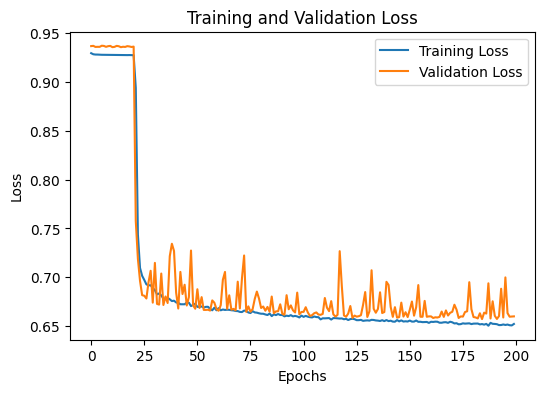

In [55]:
lstm_mapper_weights_file = os.path.join(
    weights_dir, f"{data_set}_lstm_it_{iteration}.mapper.exp.weights.h5"
)

# Train or load the mapper
if os.path.exists(lstm_mapper_weights_file):
    lstm_mapper.load_weights(lstm_mapper_weights_file)
    print("Mapper LSTM weights loaded from file.")
else:
    history = lstm_mapper.fit(
        x_train_seq, z_train_seq, epochs=200, batch_size=8, validation_split=0.1
    )
    lstm_mapper.save_weights(lstm_mapper_weights_file)
    print("Mapper LSTM weights saved to file.")

    # Plot training history
    plt.figure(figsize=(6, 4))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

**Prediction**

In [56]:
(
    x_train_seq,
    x_test_seq,
    y_train_seq,
    y_test_seq,
    z_train_seq,
    z_test_seq,
) = train_test_split(
    EIT_seq,
    perm_array_seq,
    latent_rep,
    test_size=0.1,
    shuffle=False,
    random_state=42,
)

In [57]:
def generate_perm_from_eit(voltage_measurements, lstm_mapper, vae_decoder):
    pred_latent = lstm_mapper.predict(voltage_measurements)
    perm_pred = vae_decoder.predict(pred_latent).reshape(-1, 2840)
    return perm_pred

In [58]:
predicted_permittivities = generate_perm_from_eit(x_test_seq, lstm_mapper, vae.decoder)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


**Results**

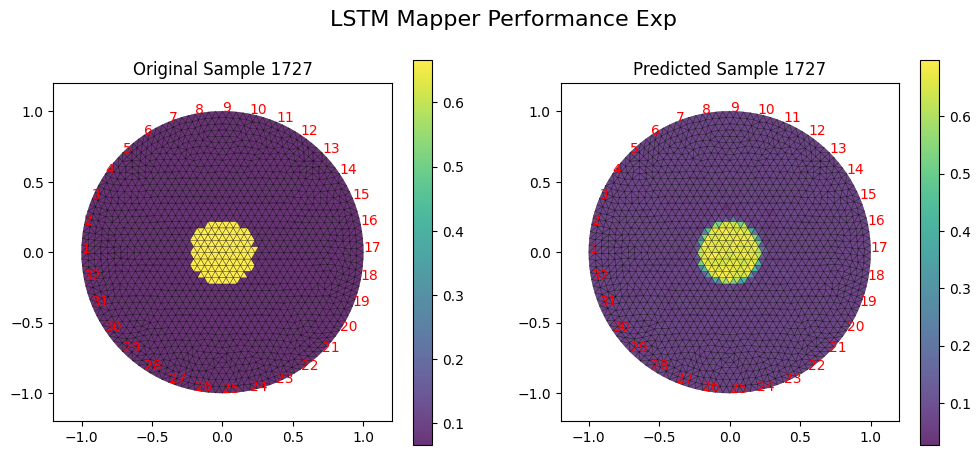

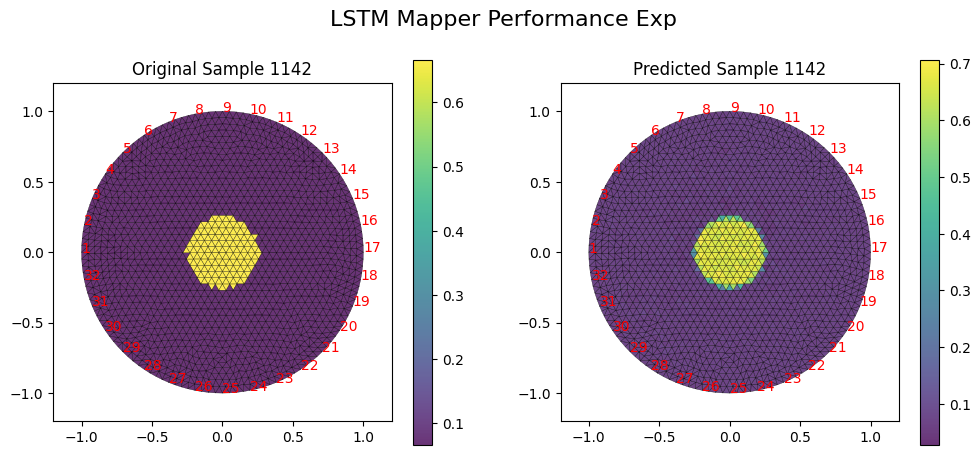

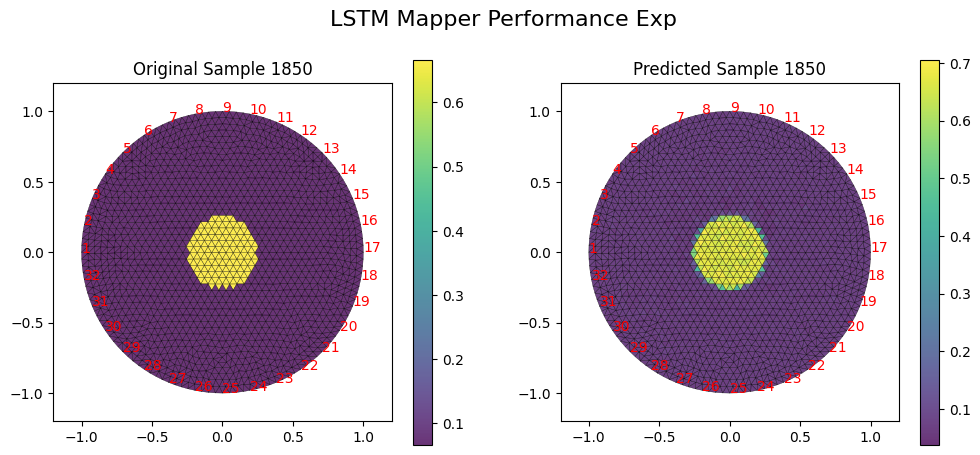

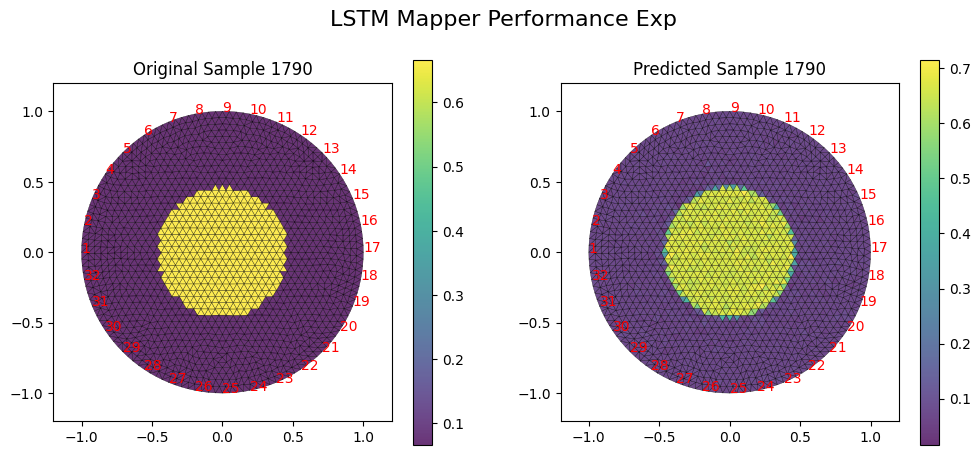

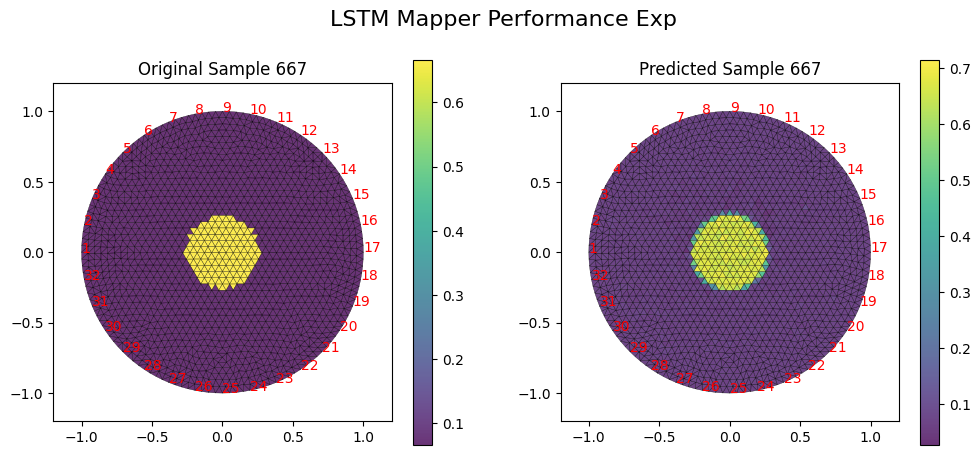

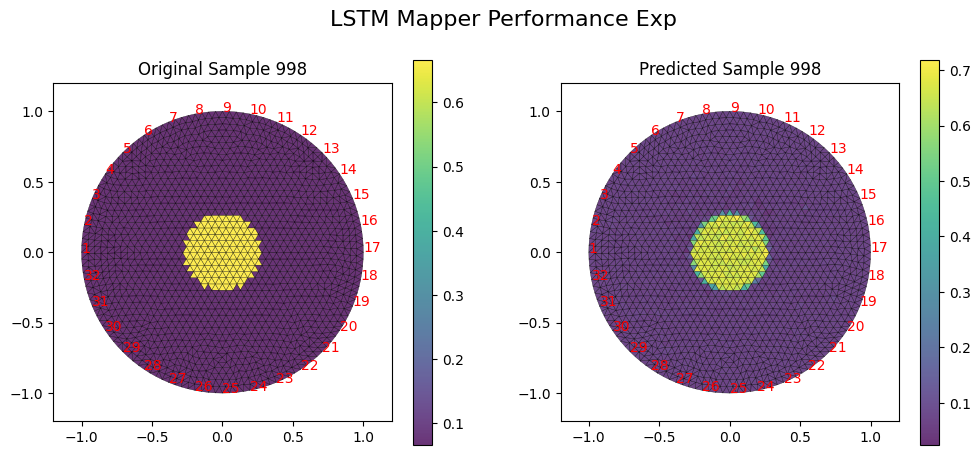

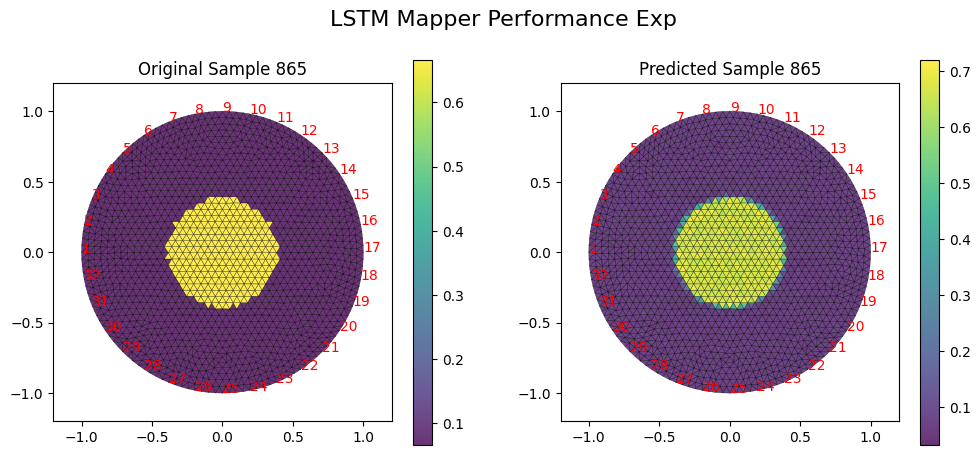

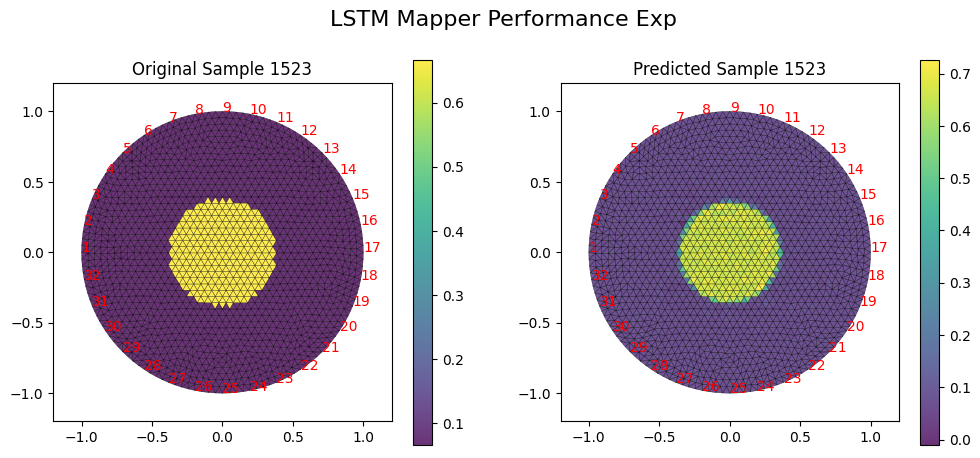

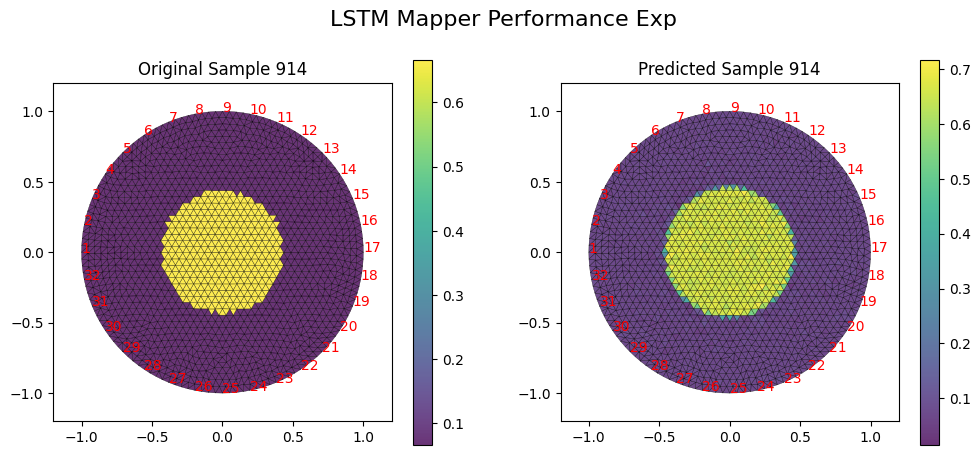

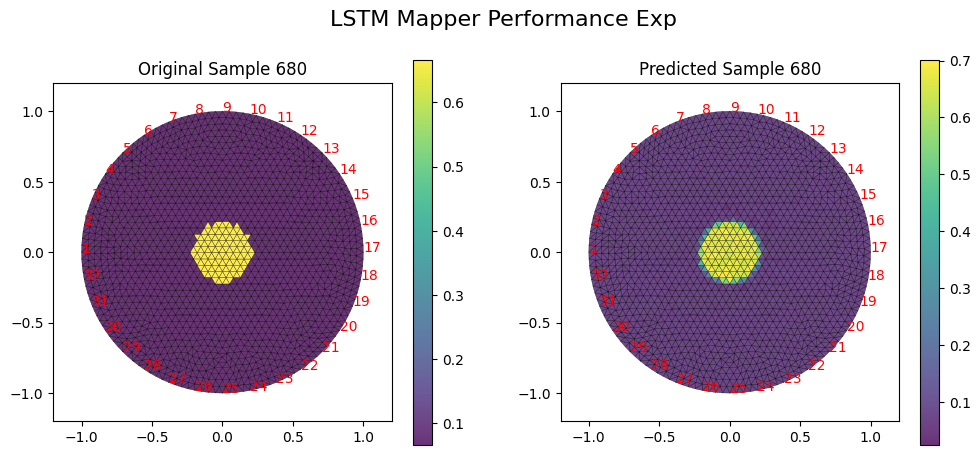

In [59]:
random_indices, selected_true_perms, selected_predicted_perms = select_random_instances(
    x_test_seq, y_test_seq, predicted_permittivities, num_instances=10
)

# Plotting and saving mesh plots
mesh_plot_comparisons(
    mesh_obj,
    random_indices,
    selected_true_perms,
    selected_predicted_perms,
    save_dir="LSTM_Mapper_Mesh_Plots_Exp1",
    gif_name="LSTM_Mapper.gif",
    gif_title="LSTM Mapper Performance Exp",
)

**Error plot**

In [60]:
perm_error = calculate_perm_error(y_test_seq, predicted_permittivities)

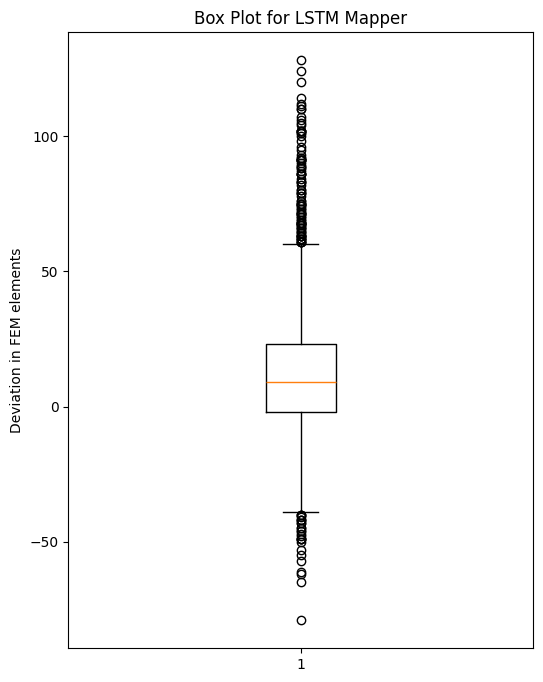

In [61]:
plot_boxplot(
    data=perm_error,
    ylabel="Deviation in FEM elements",
    title="Box Plot for LSTM Mapper",
    savefig_name="LSTM_Mapper_Boxplot(snr_30).png",
    save_dir="LSTM_Mapper_Mesh_Plots_Exp1",
)

In [62]:
mean_deviation = np.mean(perm_error)
median_deviation = np.median(perm_error)
standard_deviation = np.std(perm_error)
max_dev = np.max(perm_error)
min_dev = np.min(perm_error)

print(
    f"Mean Deviation: {mean_deviation:.2f},\t\t-> {mean_deviation/mesh_obj.n_elems*100:.2f}%"
)
print(
    f"Median Deviation: {median_deviation:.2f},\t-> {median_deviation/mesh_obj.n_elems*100:.2f}%"
)
print(
    f"Standard Deviation: {standard_deviation:.2f},\t-> {standard_deviation/mesh_obj.n_elems*100:.2f}%"
)
print(f"Max Deviation: {max_dev:.2f},\t\t-> {max_dev/mesh_obj.n_elems*100:.2f}%")
print(f"Min Deviation: {min_dev:.2f},\t\t-> {min_dev/mesh_obj.n_elems*100:.2f}%")

Mean Deviation: 12.43,		-> 0.44%
Median Deviation: 9.00,	-> 0.32%
Standard Deviation: 25.24,	-> 0.89%
Max Deviation: 128.00,		-> 4.51%
Min Deviation: -79.00,		-> -2.78%


**Time sequence**

In [63]:
x_test_seq.shape, y_test_seq.shape, predicted_permittivities.shape

((2078, 4, 32, 32, 1), (2078, 2840, 1), (2078, 2840))

In [64]:
def get_obj_FEMs(perm):
    obj_pms = np.where(perm > np.mean(perm))[0]
    return len(obj_pms)

In [65]:
rs_true = list()
rs_pred = list()

for i, ele in enumerate(predicted_permittivities):
    rs_true.append(get_obj_FEMs(ele))
    rs_pred.append(get_obj_FEMs(y_test_seq[i, :, 0]))

rs_true = np.array(rs_true)
rs_pred = np.array(rs_pred)

In [66]:
def scale_value(value, new_min=0.2, new_max=0.5):
    old_min, old_max = np.min(value), np.max(value)
    return new_min + (value - old_min) * (new_max - new_min) / (old_max - old_min)


rs_true = scale_value(rs_true)
rs_pred = scale_value(rs_pred)

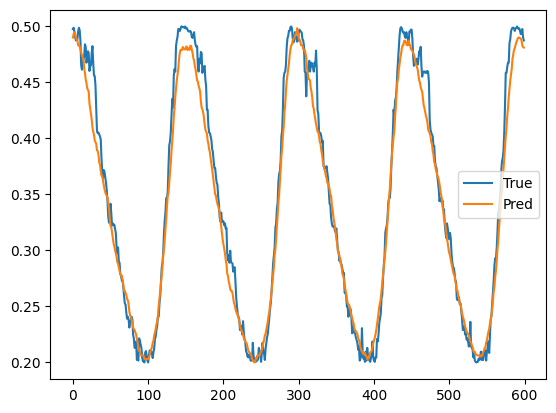

In [67]:
plt.plot(rs_true[:600], label="True")
plt.plot(rs_pred[:600], label="Pred")
plt.legend()

In [68]:
Lplt = LinePlot()

In [69]:
Lplt.add_yvals(rs_true[:600], y_name="True")
Lplt.add_yvals(rs_pred[:600], y_name="Pred")

Added True with 600 entries.
Current data stack:
       True
0  0.497170
1  0.498302
2  0.494906
3  0.489811
4  0.486981
Added Pred with 600 entries.
Current data stack:
       True      Pred
0  0.497170  0.489529
1  0.498302  0.492670
2  0.494906  0.494241
3  0.489811  0.493717
4  0.486981  0.489529


In [70]:
Lplt.export(f_name="line_results.csv")

**Export**

Current data stack:
       True      Pred  x
0  0.497170  0.489529  0
1  0.498302  0.492670  1
2  0.494906  0.494241  2
3  0.489811  0.493717  3
4  0.486981  0.489529  4

***********
LaTeX code:
***********

\begin{figure}[h]
    \centering
    \tikzstyle{every node}=[font=\footnotesize]
    \begin{tikzpicture}
        \begin{axis}[
            ylabel={y-label},
            xlabel={x-label},
            % xtick={0,1,...,10},
            width=7.5cm,
            height=3cm,
            at={(0cm,0cm)},
            scale only axis,
            axis background/.style={fill=white},
            grid=both,
            legend columns = 2,
            legend style={at={(0,1.05)}, legend cell align=left, align=left, draw=white!15!black, mark options={draw=none}, anchor=south west},
         ]
        \addplot[] 
        	table[x=x,y=True,col sep=comma]{line_results.csv};
        \addlegendentry{True};
        \addplot[] 
        	table[x=x,y=Pred,col sep=comma]{line_results.csv};
   